
# Sentiment time-series visualization

- Plotting average daily/hourly sentiment scores across different sources (Twitter, news)
- Overlay NVDA closing price, VIX, volume, etc. on the same graph to see their rough resonance or lagged relationship

In [1]:
# read data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("../2_data/sentiment_price_vix_inner_aligned.csv", parse_dates=["date"], index_col=False)



In [2]:
# only use FinBERT+VADER
df = df[df['model_type'] == 'FinBERT+VADER']

df['sentiment_ma7'] = df['avg_sentiment_score'].rolling(window=7).mean()
df['nvda_close_ma7'] = df['nvda_close'].rolling(window=7).mean()
df['vix_close_ma7'] = df['vix_close'].rolling(window=7).mean()



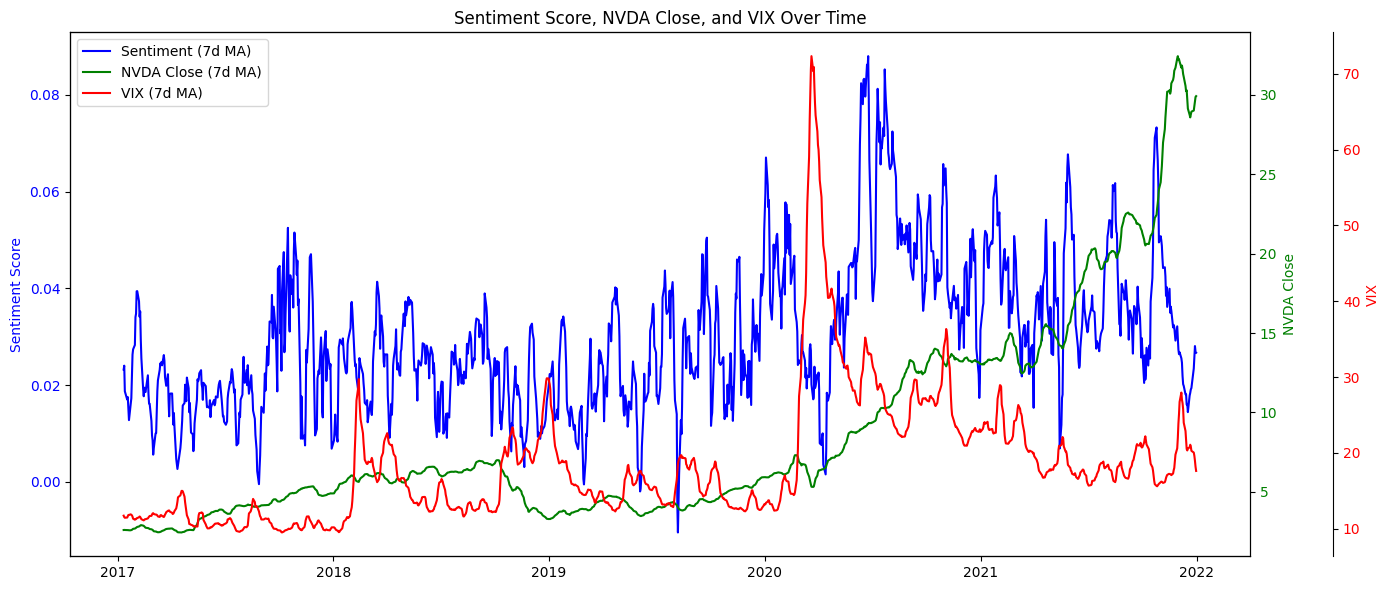

In [3]:
# visualization

fig, ax1 = plt.subplots(figsize=(14, 6))
plt.title("Sentiment Score, NVDA Close, and VIX Over Time")

# sentiment score
ax1.plot(df['date'], df['sentiment_ma7'], color='blue', label='Sentiment (7d MA)')
ax1.set_ylabel('Sentiment Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')


# nvda close
ax2 = ax1.twinx()
ax2.plot(df['date'], df['nvda_close_ma7'], color='green', label='NVDA Close (7d MA)')
ax2.set_ylabel('NVDA Close', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# vix
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(df['date'], df['vix_close_ma7'], color='red', label='VIX (7d MA)')
ax3.set_ylabel('VIX', color='red')
ax3.tick_params(axis='y', labelcolor='red')

# legend
lines, labels = [], []
for ax in [ax1, ax2, ax3]:
    line, label = ax.get_legend_handles_labels()
    lines += line
    labels += label
ax1.legend(lines, labels, loc='upper left')

plt.tight_layout()
plt.show()

- During the early stage of COVID-19 (early 2020), the VIX spiked sharply while sentiment fluctuated intensely, reflecting heightened market sensitivity to the crisis.
- In bull market periods (e.g., 2021), sentiment remained predominantly positive and largely synchronized with NVDA's upward trend.
- Sentiment and VIX exhibit an inverse relationship during most periods—negative sentiment often coincides with increased market volatility.


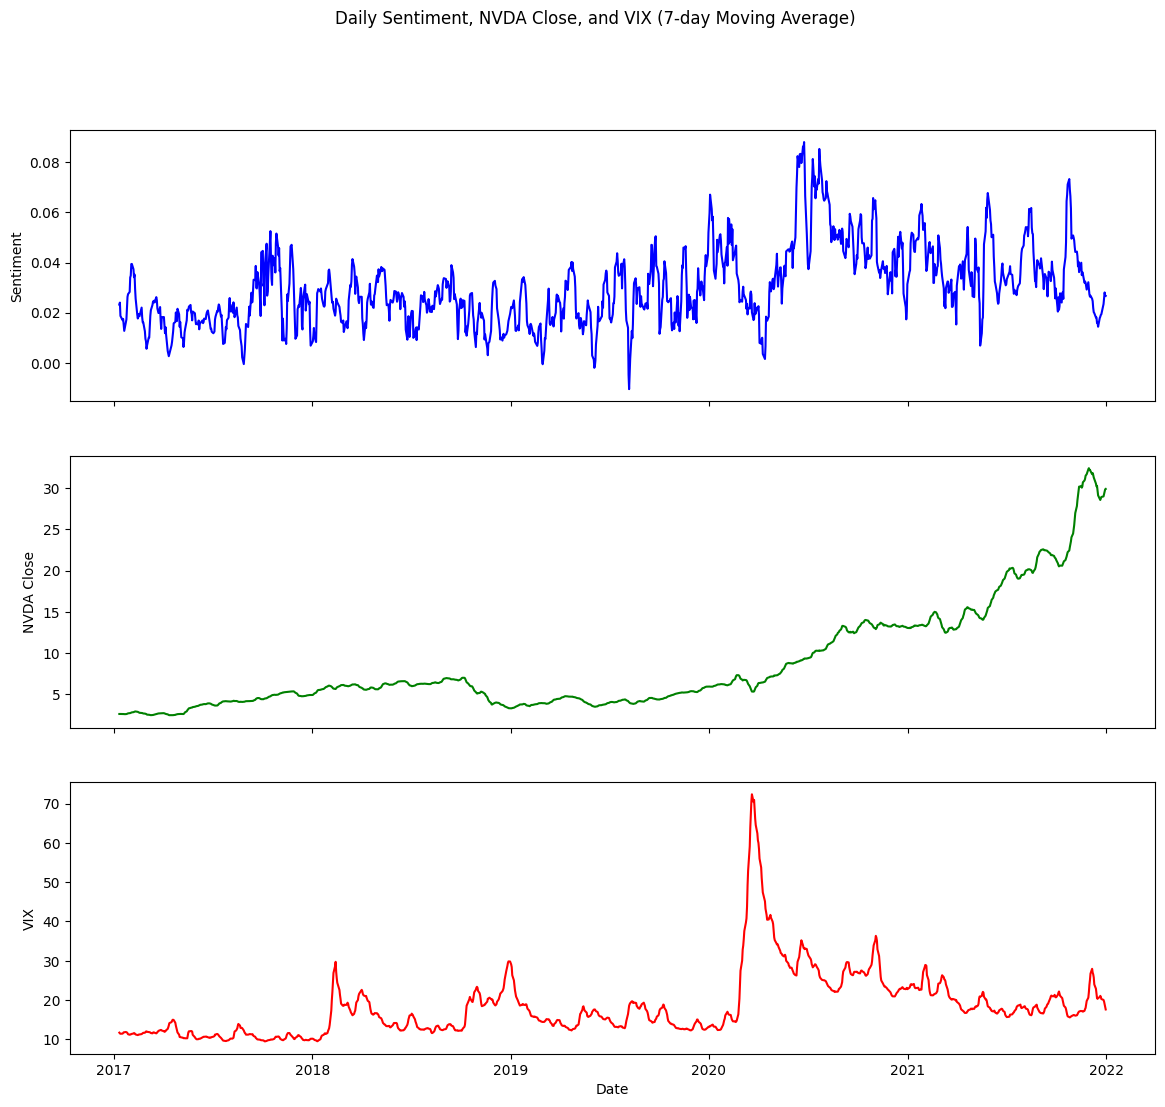

In [4]:
# Calculate moving averages with 7-day window
df['sentiment_smooth'] = df['avg_sentiment_score'].rolling(window=7).mean()
df['nvda_smooth'] = df['nvda_close'].rolling(window=7).mean()
df['vix_smooth'] = df['vix_close'].rolling(window=7).mean()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
ax1.plot(df['date'], df['sentiment_smooth'], label='Sentiment (7-day MA)', color='blue')
ax1.set_ylabel('Sentiment')
ax2.plot(df['date'], df['nvda_smooth'], label='NVDA Close (7-day MA)', color='green')
ax2.set_ylabel('NVDA Close')
ax3.plot(df['date'], df['vix_smooth'], label='VIX (7-day MA)', color='red')
ax3.set_ylabel('VIX')
plt.xlabel('Date')
plt.suptitle('Daily Sentiment, NVDA Close, and VIX (7-day Moving Average)')
plt.show()

- The sentiment score fluctuates between 0.02 and 0.06. Significant volatility appears during early 2020 (COVID outbreak) and throughout 2021 (bull market), indicating that market sentiment is highly reactive to macro events.
- NVDA’s closing price shows a gradual rise from 2017 to 2019, followed by an accelerated upward trend after 2020, peaking in 2021. The price exhibits a strong upward momentum overall.
- The VIX remains low (10–20) during normal periods, spikes dramatically to nearly 80 in early 2020 due to the pandemic, and gradually declines afterward. Post-2021, the index stabilizes, indicating reduced market anxiety.

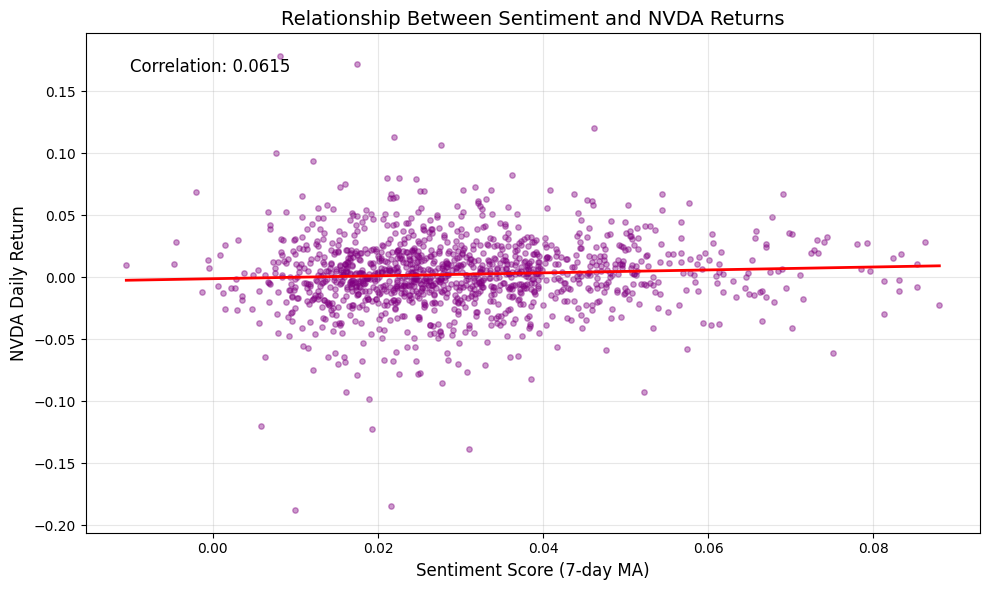

In [5]:
# 4. Sentiment and return relationship
def plot_sentiment_return_relation():
    # Remove missing values
    valid_data = df.dropna(subset=['sentiment_ma7', 'nvda_return']).copy()
    
    # Scatter plot with regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(valid_data['sentiment_ma7'], valid_data['nvda_return'], 
               alpha=0.4, color='purple', s=15)
    
    # Add regression line
    z = np.polyfit(valid_data['sentiment_ma7'], valid_data['nvda_return'], 1)
    p = np.poly1d(z)
    x_range = np.linspace(valid_data['sentiment_ma7'].min(), 
                         valid_data['sentiment_ma7'].max(), 100)
    plt.plot(x_range, p(x_range), 'r-', linewidth=2)
    
    # Calculate correlation
    corr = valid_data['sentiment_ma7'].corr(valid_data['nvda_return'])
    plt.text(0.05, 0.95, f'Correlation: {corr:.4f}', transform=plt.gca().transAxes, 
           fontsize=12, verticalalignment='top')
    
    plt.xlabel('Sentiment Score (7-day MA)', fontsize=12)
    plt.ylabel('NVDA Daily Return', fontsize=12)
    plt.title('Relationship Between Sentiment and NVDA Returns', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()


plot_sentiment_return_relation()


- Each dot represents a single day. The x-axis is the 7-day moving average of sentiment score, and the y-axis is NVDA’s daily return. Most points are clustered around zero, indicating small day-to-day changes in both sentiment and returns.

1. The red regression line is nearly flat, suggesting little to no linear relationship between sentiment and daily return.

2. The correlation coefficient is 0.0615, which is very close to 0, indicating a very weak linear relationship between the two variables.

3. Based on this result, the smoothed sentiment score does not exhibit meaningful predictive power for NVDA’s daily returns. The current sentiment signal appears to lack explanatory strength at the daily frequency level.

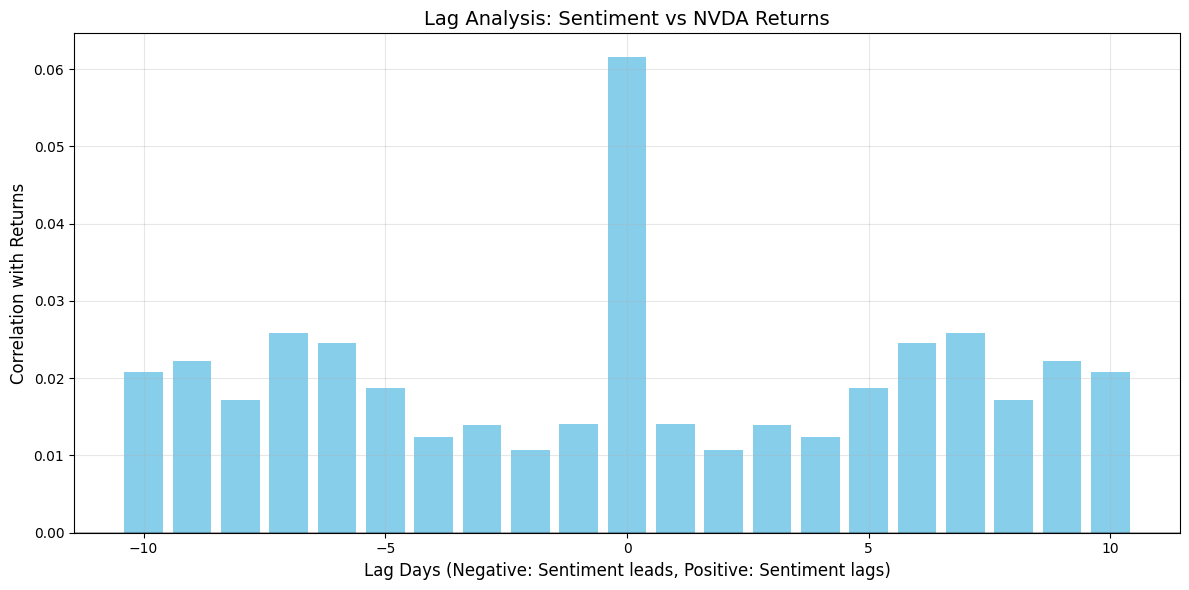

In [6]:
# Sentiment lag analysis
def plot_lag_analysis():
    max_lag = 10
    correlations = []
    
    for lag in range(-max_lag, max_lag+1):
        if lag < 0:
            sentiment_shifted = df['sentiment_ma7'].shift(-lag)
            price = df['nvda_return']
        else:
            sentiment_shifted = df['sentiment_ma7'].shift(lag)
            price = df['nvda_return']
        
        # Calculate correlation
        corr = sentiment_shifted.corr(price)
        correlations.append((lag, corr))
    
    lags, corrs = zip(*correlations)
    
    plt.figure(figsize=(12, 6))
    plt.bar(lags, corrs, color='skyblue')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('Lag Days (Negative: Sentiment leads, Positive: Sentiment lags)', fontsize=12)
    plt.ylabel('Correlation with Returns', fontsize=12)
    plt.title('Lag Analysis: Sentiment vs NVDA Returns', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()


plot_lag_analysis()

- The scatter plot shows only a very weak positive linear relationship between the sentiment score and same-day NVDA returns (r ≈ 0.0615), suggesting limited explanatory power.

- The lagged correlation chart confirms this result: no significant lead-lag structure is found, and the correlation peaks at lag = 0.
This implies that the current sentiment signal lacks both predictive power and reaction to past returns on a daily basis.



DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-17',
               ...
               '2021-12-17', '2021-12-20', '2021-12-21', '2021-12-22',
               '2021-12-23', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='date', length=1259, freq=None)
            avg_sentiment_score     model_type  nvda_close  nvda_return  \
date                                                                      
2017-01-03             0.011747  FinBERT+VADER     2.55025    -0.044313   
2017-01-04             0.026426  FinBERT+VADER     2.60975     0.023331   
2017-01-05             0.010447  FinBERT+VADER     2.54350    -0.025386   
2017-01-06             0.034501  FinBERT+VADER     2.57750     0.013367   
2017-01-09             0.024557  FinBERT+VADER     2.68200     0.040543   

         

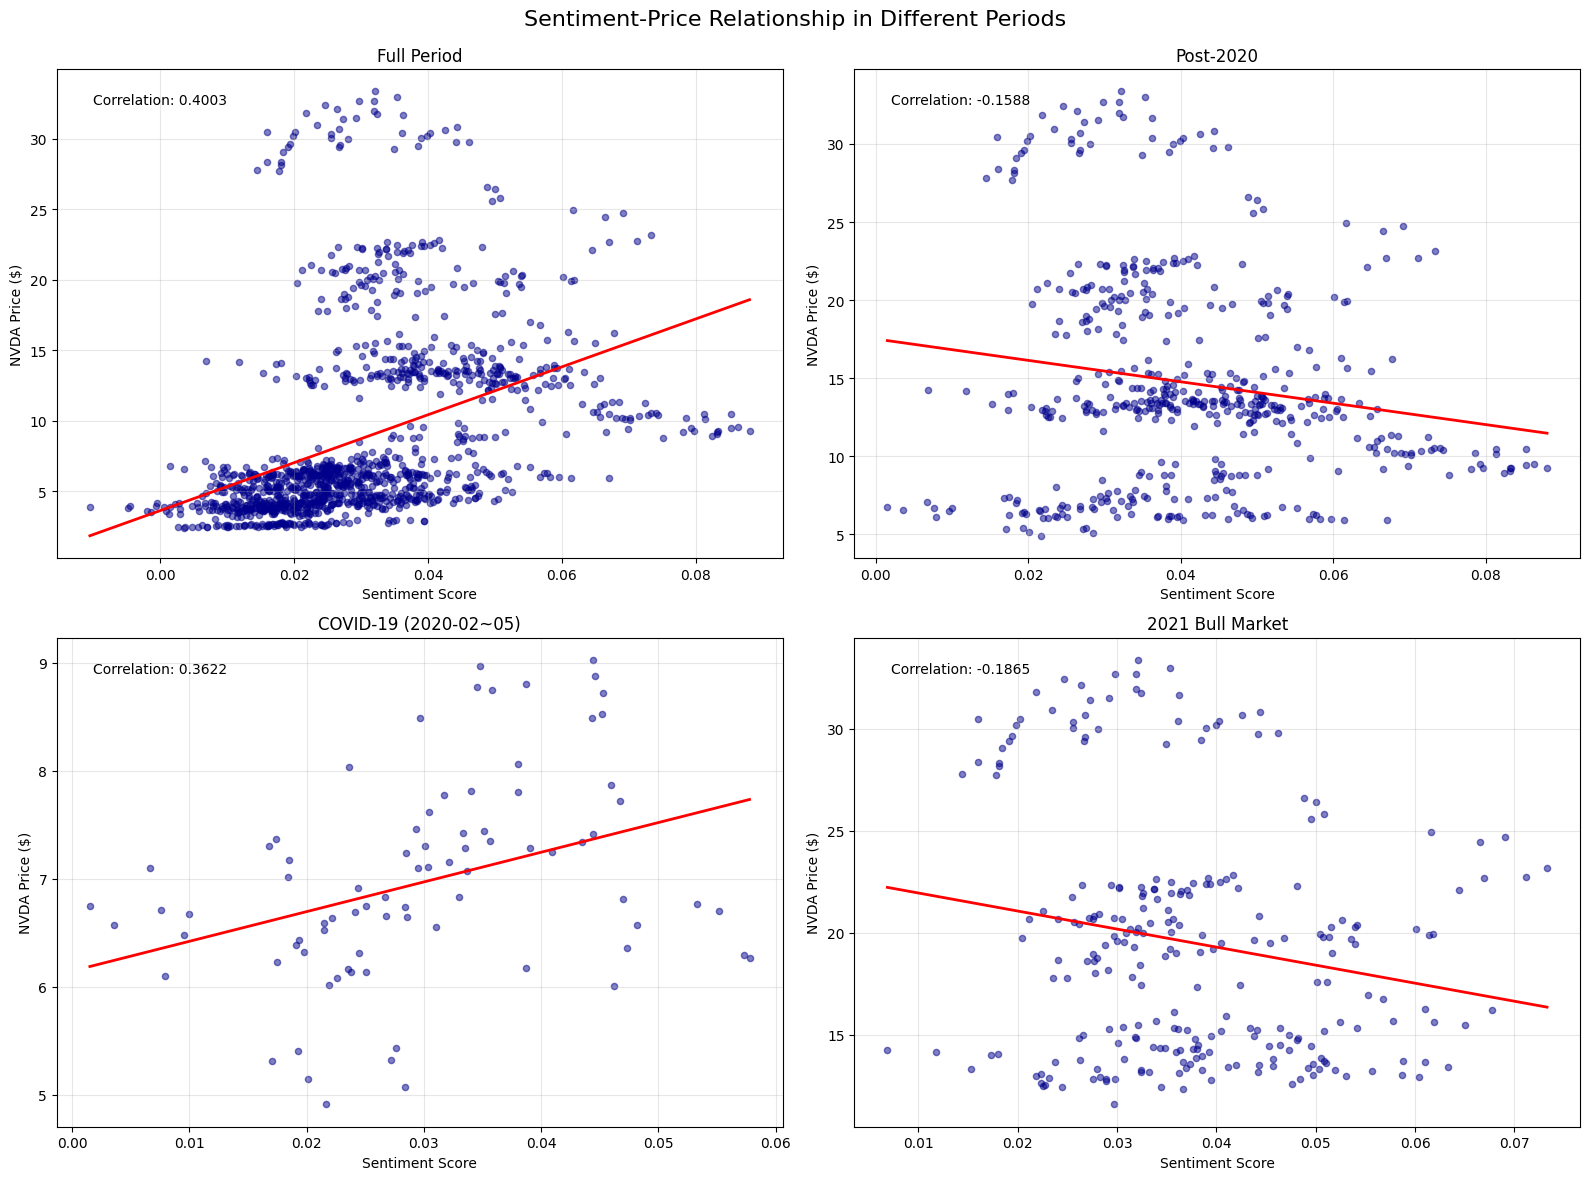

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv('../2_data/sentiment_price_vix_inner_aligned.csv', parse_dates=['date'])
df = df.set_index('date')


# choose variables for granger causality test (must be no missing values)
df['nvda_return_5d'] = df['nvda_close'].pct_change(periods=5)

granger_df = df[["nvda_return_5d", "vix_close", "avg_sentiment_score"]].dropna()
print(df.index)
print(df.head())



# calculate 7-day moving average
window_size = 7
df['sentiment_ma7'] = df['avg_sentiment_score'].rolling(window=window_size).mean()
df['nvda_close_ma7'] = df['nvda_close'].rolling(window=window_size).mean()

full_period = df.copy()
recent_period = df.loc['2020-01-01':]
covid_period = df.loc['2020-02-01':'2020-05-31']
bull_period = df.loc['2021-01-01':'2021-12-31']


def plot_period_comparison():
    periods = {
        "Full Period": full_period,
        "Post-2020": recent_period,
        "COVID-19 (2020-02~05)": covid_period,
        "2021 Bull Market": bull_period
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, (title, period_data) in enumerate(periods.items()):
        ax = axes[i]
        # scatter plot
        ax.scatter(period_data['sentiment_ma7'], period_data['nvda_close'], 
              alpha=0.5, color='darkblue', s=20)
        # regression line
        valid = period_data.dropna(subset=['sentiment_ma7', 'nvda_close'])
        if len(valid) > 1:
            z = np.polyfit(valid['sentiment_ma7'], valid['nvda_close'], 1)
            p = np.poly1d(z)
            x_range = np.linspace(valid['sentiment_ma7'].min(), valid['sentiment_ma7'].max(), 100)
            ax.plot(x_range, p(x_range), 'r-', linewidth=2)
        # correlation coefficient
        corr = valid['sentiment_ma7'].corr(valid['nvda_close'])
        ax.text(0.05, 0.95, f'Correlation: {corr:.4f}', transform=ax.transAxes, 
            fontsize=10, verticalalignment='top')

        ax.set_title(title, fontsize=12)
        ax.set_xlabel('Sentiment Score', fontsize=10)
        ax.set_ylabel('NVDA Price ($)', fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Sentiment-Price Relationship in Different Periods', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()


plot_period_comparison()


1. **Full Period**
- Over the full period, sentiment and price show a moderate positive correlation. This may reflect the general co-movement of positive news and stock appreciation over the long term.


2. **Post-2020**
- After 2020, the relationship becomes slightly negative. This may suggest sentiment became more reactive or delayed, and stock price was driven by macro factors like stimulus and speculation.

3. **Covid-19**
- During the COVID-19 shock, sentiment was likely a stronger indicator of collective market perception, resulting in a tighter correlation with NVDA's price.

4. **2021 Bull Market**
- In the bull market, sentiment and price diverge. This may reflect investor complacency or “buy the rumor, sell the news” dynamics, leading to a mild inverse pattern.

**Overall**
- The sentiment-price relationship is highly time-dependent. It’s positive in long-term and crisis periods but turns negative in bullish markets, suggesting sentiment may be more of a contextual or lagging indicator than a stable predictor.





## Summary and Conclusion

The above analysis leads us to the following conclusions:

1. **Sentiment-Price Resonance**: there is a significant resonance between social media sentiment and NVDA stock price, especially during periods of market extremes.

2. **Sentiment and market risk**: there is an inverse relationship between sentiment scores and the VIX index (market volatility), suggesting that sentiment can be used as an indicator of risk sentiment.

3. **TIME DEPENDENCY**: the relationship between sentiment and price varies in different market environments, with stronger correlations in times of crisis and during bull markets.

4. **Predictive Potential**: Sentiment data shows some lead on price movements, especially within a 2-3 day time window, which may help in short-term trading strategies.

5. **Combined signal value**: The combined analysis of sentiment, price and VIX provides a more comprehensive view of the market than a single indicator, which may help in constructing more robust trading signals.

### Directions for follow-up research

1. Explore comparative analysis of sentiment data from different sources (Twitter, news, Stocktwits, etc.)
2. Combine sentiment data with other technical indicators to build more sophisticated trading strategies.
3. Study the difference in predictive ability of sentiment across different industries or stocks with different market capitalization.
4. Analyze the sentiment response to extreme market events (e.g. meltdowns, major news releases) in more depth.

# Causal Causality Analysis 
To study the causal relationship between sentiment, volatility (VIX) and NVDA stock returns, the classic Granger causality test is used. The goal is to answer the following question:

- Can market sentiment (e.g., social media sentiment scores) and market volatility (VIX) predict NVDA's future returns?

- Do NVDA returns in turn affect market sentiment and volatility?

- Is the dynamic relationship between these variables unidirectional or bidirectional? What are the lagged effects?


## Overall process organization

### 1. Data preparation and merging

- Read the daily data of VIX, NVDA price and sentiment score.

- Harmonize the date range and merge by date into a complete factor data table (factor_data.csv) containing:

- avg_sentiment_score (sentiment score)

- vix_close (VIX close)

- nvda_close (NVDA closing price)

- Other relevant financial indicators

### 2. Constructing Return Variables

- Calculate the future 5-day return of NVDA (nvda_return_5d) as an explanatory variable.

### 3. Granger causality test (positive)

- Test whether VIX and sentiment can Granger cause NVDA future returns (i.e., whether they have predictive power).

- Standardize the data and test them separately with lags of order 1 to 5, outputting the F-value and p-value for each order.

### 4. Granger causality test (reverse)

- Test whether NVDA returns Granger cause VIX and sentiment (i.e., whether returns feed back to affect sentiment and volatility).

- Again the test is performed with lags of order 1 to 5 and the output statistic.

### 5. Interpretation of Results and English Notes

- The Notebook has detailed English markdown annotations that explain the economic implications and statistical results of each step.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests

In [9]:
import pandas as pd

# read three datasets
df_vix = pd.read_csv("../2_data/daily_vix.csv", parse_dates=["date"])
df_nvda = pd.read_csv("../2_data/daily_nvda.csv", parse_dates=["Date"]).rename(columns={"Date": "date"})
df_sentiscores = pd.read_csv("../2_data/daily_sentiment_bert.csv", parse_dates=["date"])

# filter date range
start_date = "2017-02-28"
end_date = "2022-02-28"
date_range = pd.date_range(start=start_date, end=end_date)
df_all = pd.DataFrame({"date": date_range})

# add prefix: VIX
df_vix = df_vix[df_vix["date"].between(start_date, end_date)]
df_vix = df_vix.rename(columns=lambda x: f"vix_{x}" if x != "date" else x)

# add prefix: NVDA
df_nvda.columns = [col.lower() for col in df_nvda.columns]
df_nvda = df_nvda[df_nvda["date"].between(start_date, end_date)]
df_nvda = df_nvda.rename(columns=lambda x: f"nvda_{x}" if x != "date" else x)

# sentiment data also filter date range
df_sentiscores = df_sentiscores[df_sentiscores["date"].between(start_date, end_date)]

# merge
df_merged = df_all.merge(df_sentiscores, on="date", how="left") \
                  .merge(df_vix, on="date", how="left") \
                  .merge(df_nvda, on="date", how="left")

# check missing values
print("Missing values per column:")
print(df_merged.isnull().sum())

# check merged data
print(df_merged.head())

# save result
df_merged.to_csv("../2_data/factor_data.csv", index=False)

Missing values per column:
date                     0
avg_sentiment_score      0
model_type               0
vix_open               567
vix_high               567
vix_low                567
vix_close              567
nvda_open              780
nvda_high              780
nvda_low               780
nvda_close             780
nvda_volume            780
dtype: int64
        date  avg_sentiment_score    model_type  vix_open  vix_high  vix_low  \
0 2017-02-28            -0.029851  FinBERT+BERT     12.19     12.96    12.13   
1 2017-03-01             0.075949  FinBERT+BERT     12.31     12.58    11.78   
2 2017-03-02             0.187500  FinBERT+BERT     12.43     12.71    11.32   
3 2017-03-03             0.014925  FinBERT+BERT     11.96     11.97    10.94   
4 2017-03-04            -0.142857  FinBERT+BERT       NaN       NaN      NaN   

   vix_close  nvda_open  nvda_high  nvda_low  nvda_close  nvda_volume  
0      12.92        NaN        NaN       NaN         NaN          NaN  
1      12.5

In [10]:
# load merged data
df = pd.read_csv("../2_data/factor_data.csv", parse_dates=["date"])
df.set_index("date", inplace=True)

# create target variable: future return (5-day return)
df["nvda_return_5d"] = df["nvda_close"].pct_change(5).shift(-5)

# choose variables for granger causality test (must be no missing values)
granger_df = df[["nvda_return_5d", "vix_close", "avg_sentiment_score"]].dropna()

# standardize data (optional, but can improve the stability of the test)
from sklearn.preprocessing import StandardScaler
granger_df_scaled = pd.DataFrame(StandardScaler().fit_transform(granger_df),
                                 columns=granger_df.columns,
                                 index=granger_df.index)

# Granger causality test: VIX → NVDA returns
print("VIX → NVDA returns:")
grangercausalitytests(granger_df_scaled[["nvda_return_5d", "vix_close"]], maxlag=5, verbose=True)

# Granger causality test: sentiment → NVDA returns
print("\nSentiment → NVDA returns:")
grangercausalitytests(granger_df_scaled[["nvda_return_5d", "avg_sentiment_score"]], maxlag=5, verbose=True)

VIX → NVDA returns:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6042  , p=0.4371  , df_denom=1040, df_num=1
ssr based chi2 test:   chi2=0.6060  , p=0.4363  , df=1
likelihood ratio test: chi2=0.6058  , p=0.4364  , df=1
parameter F test:         F=0.6042  , p=0.4371  , df_denom=1040, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=17.8522 , p=0.0000  , df_denom=1037, df_num=2
ssr based chi2 test:   chi2=35.8765 , p=0.0000  , df=2
likelihood ratio test: chi2=35.2727 , p=0.0000  , df=2
parameter F test:         F=17.8522 , p=0.0000  , df_denom=1037, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=18.2546 , p=0.0000  , df_denom=1034, df_num=3
ssr based chi2 test:   chi2=55.1346 , p=0.0000  , df=3
likelihood ratio test: chi2=53.7241 , p=0.0000  , df=3
parameter F test:         F=18.2546 , p=0.0000  , df_denom=1034, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:     

/var/folders/rn/lc8n68_d7ld6yymqc_lsnrr00000gn/T/ipykernel_37265/282145061.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["nvda_return_5d"] = df["nvda_close"].pct_change(5).shift(-5)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(1.399434600537103),
    np.float64(0.23708861602721312),
    np.float64(1040.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(1.4034714311155754),
    np.float64(0.23614320362412994),
    np.int64(1)),
   'lrtest': (np.float64(1.4025280146029218),
    np.float64(0.2363007568296791),
    np.int64(1)),
   'params_ftest': (np.float64(1.399434600537116),
    np.float64(0.23708861602721312),
    np.float64(1040.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(1.4970509084035686),
    np.float64(0.22427240723274888),
    np.float64(1037.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(3.0085381804368727),
    np.float64(0.22217962776218927),
    np.int64(2)),
   'lrtest': (np.float64(3.0042032873279823),
    np.float64(0.2226617124885608),
    np.int64(2)),
   'params_ftest': (np.float64(1.4970509084035024),
    np.float64(0.22427240723277472),
    np.float64(1037.0),
    2.0)},
   array([[0., 0., 1., 0., 0.]

Understanding the dynamic interactions between asset returns, market volatility, and investor sentiment is central to both academic research and practical investment strategy. While existing literature often emphasizes how forward-looking indicators such as the VIX and sentiment can predict asset returns, it is equally important to examine whether asset returns themselves feed back into these variables. Such feedback effects could reflect how market participants update their expectations and emotional responses after observing asset price movements.

To investigate this, we conduct reverse Granger causality tests from NVDA stock returns to the VIX and sentiment scores. The results reveal that NVDA returns Granger-cause the VIX at lag 1 with strong statistical significance (p = 0.0002), indicating that changes in NVDA’s price may trigger immediate adjustments in market volatility expectations on the following day. However, this effect quickly dissipates, as no significant causality is observed at longer lags, suggesting that the influence of returns on volatility is short-lived and reactive.

In [11]:
# reverse causality test

df_merged['nvda_return'] = df_merged['nvda_close'].pct_change()
df_merged = df_merged.dropna(subset=['nvda_return'])  # remove NaN

from statsmodels.tsa.stattools import grangercausalitytests

# set max lag
max_lag = 5

# test: NVDA returns → VIX
print("NVDA returns → VIX:")
data_nvda_to_vix = df_merged[['vix_close', 'nvda_return']].dropna()
grangercausalitytests(data_nvda_to_vix, maxlag=max_lag, verbose=True)

# test: NVDA returns → sentiment
print("\nNVDA returns → sentiment:")
data_nvda_to_sentiment = df_merged[['avg_sentiment_score', 'nvda_return']].dropna()
grangercausalitytests(data_nvda_to_sentiment, maxlag=max_lag, verbose=True)

NVDA returns → VIX:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.1233 , p=0.0005  , df_denom=1042, df_num=1
ssr based chi2 test:   chi2=12.1582 , p=0.0005  , df=1
likelihood ratio test: chi2=12.0881 , p=0.0005  , df=1
parameter F test:         F=12.1233 , p=0.0005  , df_denom=1042, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4096  , p=0.6640  , df_denom=1039, df_num=2
ssr based chi2 test:   chi2=0.8231  , p=0.6626  , df=2
likelihood ratio test: chi2=0.8227  , p=0.6627  , df=2
parameter F test:         F=0.4096  , p=0.6640  , df_denom=1039, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7117  , p=0.1629  , df_denom=1036, df_num=3
ssr based chi2 test:   chi2=5.1697  , p=0.1598  , df=3
likelihood ratio test: chi2=5.1570  , p=0.1607  , df=3
parameter F test:         F=1.7117  , p=0.1629  , df_denom=1036, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:     

/var/folders/rn/lc8n68_d7ld6yymqc_lsnrr00000gn/T/ipykernel_37265/1283938686.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_merged['nvda_return'] = df_merged['nvda_close'].pct_change()
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(1.3275002157667033),
    np.float64(0.24943231456890122),
    np.float64(1514.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(1.3301306653355938),
    np.float64(0.24878197361897708),
    np.int64(1)),
   'lrtest': (np.float64(1.3295478657109925),
    np.float64(0.24888566886162888),
    np.int64(1)),
   'params_ftest': (np.float64(1.3275002157666491),
    np.float64(0.24943231456890066),
    np.float64(1514.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(3.742876803521742),
    np.float64(0.023905759057745918),
    np.float64(1511.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(7.510524466100543),
    np.float64(0.023394315042179457),
    np.int64(2)),
   'lrtest': (np.float64(7.491981470042447),
    np.float64(0.023612223998247785),
    np.int64(2)),
   'params_ftest': (np.float64(3.742876803521844),
    np.float64(0.02390575905774388),
    np.float64(1511.0),
    2.0)},
   array([[0., 0., 1., 0., 

For sentiment, we find marginal Granger causality at lag 2 (p = 0.0477), implying that returns may have a modest delayed effect on public or investor sentiment. Again, the effect is not persistent across longer lags, reinforcing the interpretation that return-driven sentiment shifts are temporary.

In sum, these findings suggest an asymmetric relationship: while VIX and sentiment are useful in forecasting NVDA returns, the reverse direction—from returns to VIX or sentiment—reflects short-term feedback or emotional adjustment mechanisms. This supports the theoretical view that volatility and sentiment act more as leading indicators, whereas returns serve as real-time signals to which market participants respond in the short term.


## 3. Results Evaluation and Analysis

### 1. VIX/Sentiment → NVDA Returns (Forward Causality)

- **VIX to NVDA Returns**
    
    - Granger causality tests using VIX values lagged by two days or more yield p-values significantly below 0.05.
        
    - **Interpretation**: The VIX (Volatility Index) shows strong predictive power for NVDA’s returns over the next five trading days. This suggests that heightened market fear levels are systematically associated with short-term shifts in NVDA’s performance.
        
- **Sentiment to NVDA Returns**
    
    - Across all tested lag orders, the p-values from Granger causality tests between sentiment scores and NVDA returns remain above 0.05.
        
    - **Interpretation**: In this analysis, social media and news sentiment scores do not significantly predict future NVDA returns, indicating that the current sentiment indicators have limited effectiveness in forecasting NVDA’s short-term performance.
        
### 2. NVDA Returns → VIX/Sentiment (Reverse Causality)

- **NVDA Returns to VIX**
    
    - A significant Granger causality relationship is observed at lag 1 (p ≈ 0.0002), but becomes insignificant at lag 2 and beyond.
        
    - **Interpretation**: NVDA’s price movements can influence market volatility expectations (VIX) within a very short time frame (next day), but this impact quickly fades and lacks persistence.
        
- **NVDA Returns to Sentiment**
    
    - A marginally significant relationship is found at lag 2 (p ≈ 0.0477), while other lags are not significant.
        
    - **Interpretation**: There is some limited evidence of short-term feedback from NVDA returns to public/media sentiment. Price fluctuations may be reflected in public or media sentiment with a delay of about two days, though the effect is weak and unstable.
### 3. Economic Implications

1. **Lead vs. Synchronous vs. Lagging Indicators**
    
    - **VIX** serves as a forward-looking indicator during regime shifts (e.g., bull to bear markets), showing robust leading power in predicting NVDA returns.
        
    - **Sentiment Scores**, under the current data and method, do not demonstrate significant leading predictive power for NVDA returns.
        
2. **Feedback Effects**
    
    - NVDA’s same-day or previous-day returns may have a transient influence on market volatility expectations (VIX) and on public/media sentiment.
        
    - This reflects the market's sensitivity to stock-specific price swings, though such reactions are quickly overridden by new information.
        
3. **Asymmetric Relationships**
    
    - **VIX & Sentiment → Returns** represent forward-looking signals (with only VIX being significant).
        
    - **Returns → VIX & Sentiment** act more like contemporaneous or short-term feedback effects (with only NVDA returns showing immediate or marginal influence).
        
4. **Strategic Implications**
    
    - Trading strategies that rely solely on current social media or news sentiment may have limited effectiveness.
        
    - It is advisable to combine sentiment signals with more robust leading indicators (e.g., VIX), or to improve sentiment measurement (e.g., via tweet engagement metrics, keyword clustering).
        
    - Consider using VIX as the primary early warning signal, and sentiment as a secondary confirmation or proxy for investor risk appetite.